In [15]:
# imports
import jax
jax.config.update("jax_default_device",jax.devices()[3])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from tqdm.auto import tqdm
# plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS,InducedOperatorModel,SharedOperatorPDEModel
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM
from Optimizers.solvers_base import *

from Optimizers import BlockArrowLM,LMParams


In [16]:
m = 128
obs_pts = 1
run = 1

kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = run
                                    )
                                    )
# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


# Sample collocation points for f using same uniform grid for every function
xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],15,15)
xy_ints = (xy_int_single,)*m
xy_bdys = (xy_bdy_single,)*m


xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [obs_pts]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(run)
)

# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_operators = (eval_k,)

# u_models = tuple([CholInducedRKHS(
#     xy_all[i],
#     u_operators,
#     k_u
#     ) for i in range(m)])

u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints


rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])

grid_features_u_init = jnp.vstack([(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

num_P_inducing = 200
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))

# P kernel
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_gaussianRBF(0.4)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

# P object        
# P_model = InducedOperatorModel(grid_features_u_init,k_P)
P_model = InducedOperatorModel(input_feature_sample,k_P)

num_P_params = len(grid_features_u_init)

# P, u, f object
collocation_points = xy_ints
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
    num_P_operator_params = num_P_inducing
)


In [17]:
u_init = jnp.stack(all_u_params_init)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

beta_reg = 1e-12 # change here


lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
u_sols,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg,beta_reg,
    optParams=lm_params
    )


  1%|          | 3/501 [00:03<07:34,  1.09it/s]

Iteration 0, loss = 2.722, gradnorm = 10.94, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 1.224, gradnorm = 0.9671, alpha = 0.06944, improvement_ratio = 1.013
Iteration 2, loss = 0.7822, gradnorm = 0.2744, alpha = 0.05787, improvement_ratio = 1.009


  1%|          | 5/501 [00:03<03:59,  2.07it/s]

Iteration 3, loss = 0.5693, gradnorm = 0.1551, alpha = 0.04823, improvement_ratio = 1.007
Iteration 4, loss = 0.4504, gradnorm = 0.1005, alpha = 0.04019, improvement_ratio = 1.006
Iteration 5, loss = 0.373, gradnorm = 0.06979, alpha = 0.03349, improvement_ratio = 1.005


 21%|██        | 103/501 [00:10<00:29, 13.50it/s]

Iteration 100, loss = 9.517e-06, gradnorm = 8.22e-06, alpha = 1.006e-09, improvement_ratio = 1.0


 28%|██▊       | 138/501 [00:13<00:35, 10.21it/s]


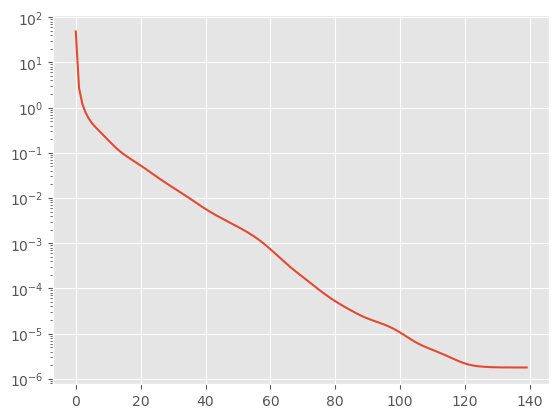

In [19]:
plt.plot(arrow_conv.loss_vals)
plt.yscale('log')

In [20]:
all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
    for obs_loc,obs_val in zip(observation_points,observation_values)])


In [21]:
# Include this line 
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))
result_df = table_u_errors(xy_fine,(u_model,)*m,u_sols,list(map(jax.vmap,u_true_functions)),all_u_params_init)

In [22]:
result_df.mean()

Percent error 1 step               0.143972
Percent error 2 step (at init)    10.276337
dtype: float64

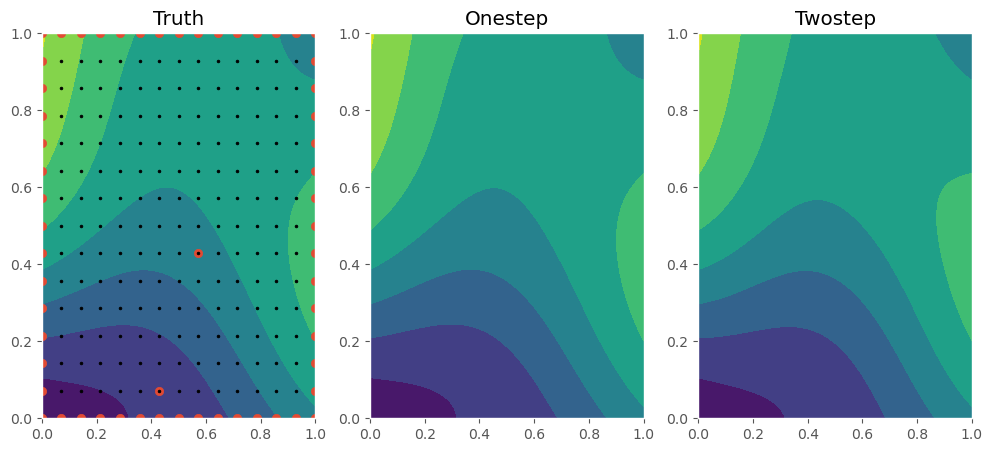

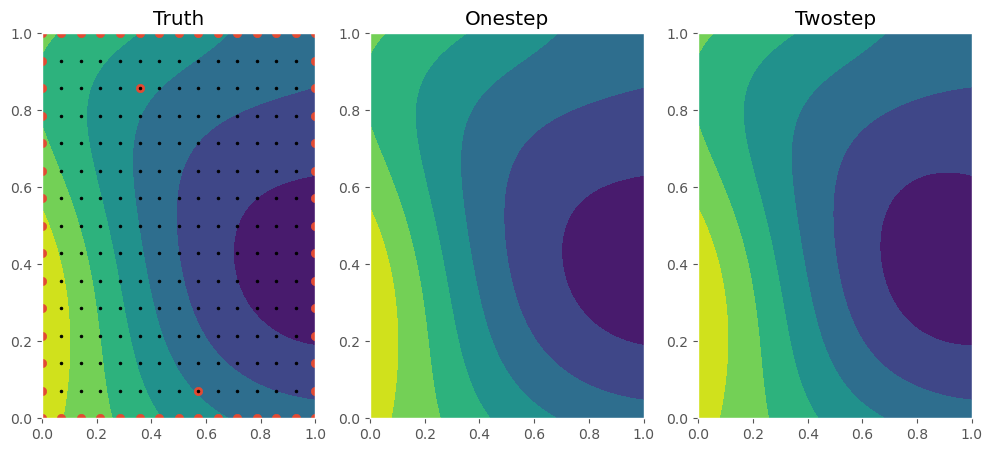

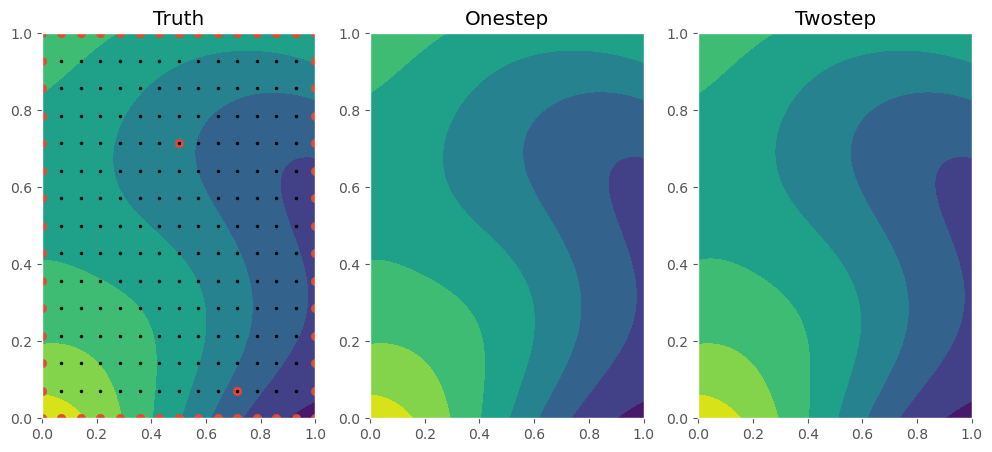

In [6]:
for i in range(m):
    xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))
    solution_index = i
    true_func_vals = jax.vmap(u_true_functions[solution_index])(xy_fine)
    onestep_vals = u_model.point_evaluate(xy_fine,u_sols[solution_index])
    interpolant_vals = u_model.point_evaluate(xy_fine,u_init[solution_index])
    # print("1step NRMSE: ",get_nrmse(true_func_vals,onestep_vals),"interpolant NRMSE: ",get_nrmse(true_func_vals,interpolant_vals))
    if i<3:
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        
        plt.tricontourf(*xy_fine.T,true_func_vals)
        plt.scatter(*xy_obs[i].T)
        plt.scatter(*collocation_points[0].T,c='black',s = 4)
        plt.title("Truth")
        plt.subplot(1,3,2)
        plt.tricontourf(*xy_fine.T,onestep_vals)
        plt.title("Onestep")
        plt.subplot(1,3,3)
        plt.tricontourf(*xy_fine.T,interpolant_vals)
        plt.title("Twostep")
        plt.show()


In [7]:
## Errors

# Phat[S] - 1 step    
P_func = lambda x: P_model.predict(x,P_sol)

# Phat[S] - 2 step
init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                        for u_params,eval_points in zip(
                                        all_u_params_init,
                                        EqnModel.collocation_points)])
rhs_stacked = EqnModel.stacked_collocation_rhs
P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
P_func2 = lambda x: P_model.predict(x,P_params_naive)
    

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):

    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])

    return P_func(model_fine_features)
    
# In sample

# Testing grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))


# True rhs's
true = [f(xy_fine) for f in rhs_functions]

pred1_5 = [
    evaluate_hatP(
    P_func,
    u, xy_fine,feature_operators) for u in u_true_functions
]

pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine,feature_operators) for u in u_true_functions
]

i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

In [8]:
i_smpl_1_5

Array(0.02949201, dtype=float64)

In [9]:
i_smpl_2

Array(0.146813, dtype=float64)

In [22]:
# In-sample error
def run_exp_i_smpl_err(m,obs_pts,run):
    '''
    Computes in-sample error for 1 step and 2 step methods.

    Args:
        m (int): Number of functions.
        obs_pts (int): Number of observed points.
        run (int): seed.
    
    Returns:
        i_opt_1_5 (float): In-sample error for Phat (1 step) for in-sample functions.
        i_opt_2 (float): In-sample error for Phat (2 step) for in-sample functions.

    '''   

    # Sample m functions
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed


    # Sample collocation points for f using same uniform grid for every function
    xy_int_single,xy_bdy_single = build_xy_grid([0,1],[0,1],15,15)
    xy_ints = (xy_int_single,)*m
    xy_bdys = (xy_bdy_single,)*m


    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(run)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_operators = (eval_k,)

    # u_models = tuple([CholInducedRKHS(
    #     xy_all[i],
    #     u_operators,
    #     k_u
    #     ) for i in range(m)])

    u_model = CholInducedRKHS(xy_all[0],u_operators,k_u)

    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints


    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        u_model.get_fitted_params(obs_loc,obs_val,lam = 1e-8)
        for obs_loc,obs_val in zip(observation_points,observation_values)])

    grid_features_u_init = jnp.vstack([(
        u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model_params in zip(xy_ints,all_u_params_init) ])

    grid_features_u_init = jnp.hstack([jnp.vstack(xy_ints),grid_features_u_init])

    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
    k_P_x_part = get_gaussianRBF(0.4)

    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
        

    # P object        
    P_model = InducedOperatorModel(grid_features_u_init,k_P)
    num_P_params = len(grid_features_u_init)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = SharedOperatorPDEModel(
        P_model,
        u_model,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
        num_P_operator_params = num_P_params
    )

    u_init = jnp.stack(all_u_params_init)
    P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

    # OPTIMIZE 
    beta_reg = 1e-8
    lm_params = LMParams(max_iter = 501,init_alpha = 1e-1,min_alpha = 1e-12,print_every = 100)
    u_sols,P_sol,arrow_conv = BlockArrowLM(
        u_init,P_init,EqnModel,beta_reg,beta_reg,
        optParams=lm_params
        )
    
    ## Errors

    # Phat[S] - 1 step    
    P_func = lambda x: P_model.predict(x,P_sol)

    # Phat[S] - 2 step
    init_P_features = jnp.vstack([EqnModel.single_eqn_features(u_params,eval_points) 
                                            for u_params,eval_points in zip(
                                            all_u_params_init,
                                            EqnModel.collocation_points)])
    rhs_stacked = EqnModel.stacked_collocation_rhs
    P_params_naive = P_model.get_fitted_params(init_P_features,rhs_stacked)
    P_func2 = lambda x: P_model.predict(x,P_params_naive)
        

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])

        return P_func(model_fine_features)
        
    # In sample

    # True rhs's
    true = [f(xy_fine) for f in rhs_functions]

    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine,feature_operators) for u in u_true_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine,feature_operators) for u in u_true_functions
    ]

    i_smpl_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    i_smpl_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_smpl_1_5, i_smpl_2

In [ ]:
a, b = run_exp_i_smpl_err(m=16,obs_pts=10,run=1)

In [26]:
a

Array(0.01934991, dtype=float64)

In [27]:
b

Array(0.02179332, dtype=float64)